# Classification Model Using XGBoost and HyperOpt

## Loading Libraries

In [1]:
# preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# ML algorithms
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# hyperopt and cross-validation
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import RepeatedStratifiedKFold

# model evaluation metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer

## Analyzing Data

In [2]:
mem = pd.read_csv('mem.csv')
nmem = pd.read_csv('nmem.csv')

In [3]:
mem['member'] = 1
nmem['member'] = 0

In [4]:
# common columns
common_col = np.intersect1d(mem.columns, nmem.columns)

common_col

array(['Age', 'Education History\\Educational degree_AB:',
       'Education History\\Educational degree_AVI',
       'Education History\\Educational degree_BA:',
       'Education History\\Educational degree_BAL',
       'Education History\\Educational degree_BFA',
       'Education History\\Educational degree_BME',
       'Education History\\Educational degree_BMU',
       'Education History\\Educational degree_BS:',
       'Education History\\Educational degree_BSJ',
       'Education History\\Educational degree_BSL',
       'Education History\\Educational degree_BSN',
       'Education History\\Educational degree_BSW',
       'Education History\\Educational degree_CAS',
       'Education History\\Educational degree_CTE',
       'Education History\\Educational degree_DVM',
       'Education History\\Educational degree_EDD',
       'Education History\\Educational degree_EDM',
       'Education History\\Educational degree_JD:',
       'Education History\\Educational degree_LLM',
     

In [5]:
new_mem1 = mem[common_col]
new_nmem1 = nmem[common_col]

In [6]:
class_mem = pd.concat([new_mem1, new_nmem1], axis=0)

In [7]:
class_mem.shape

(87001, 43)

### Correlation Analysis

<AxesSubplot:>

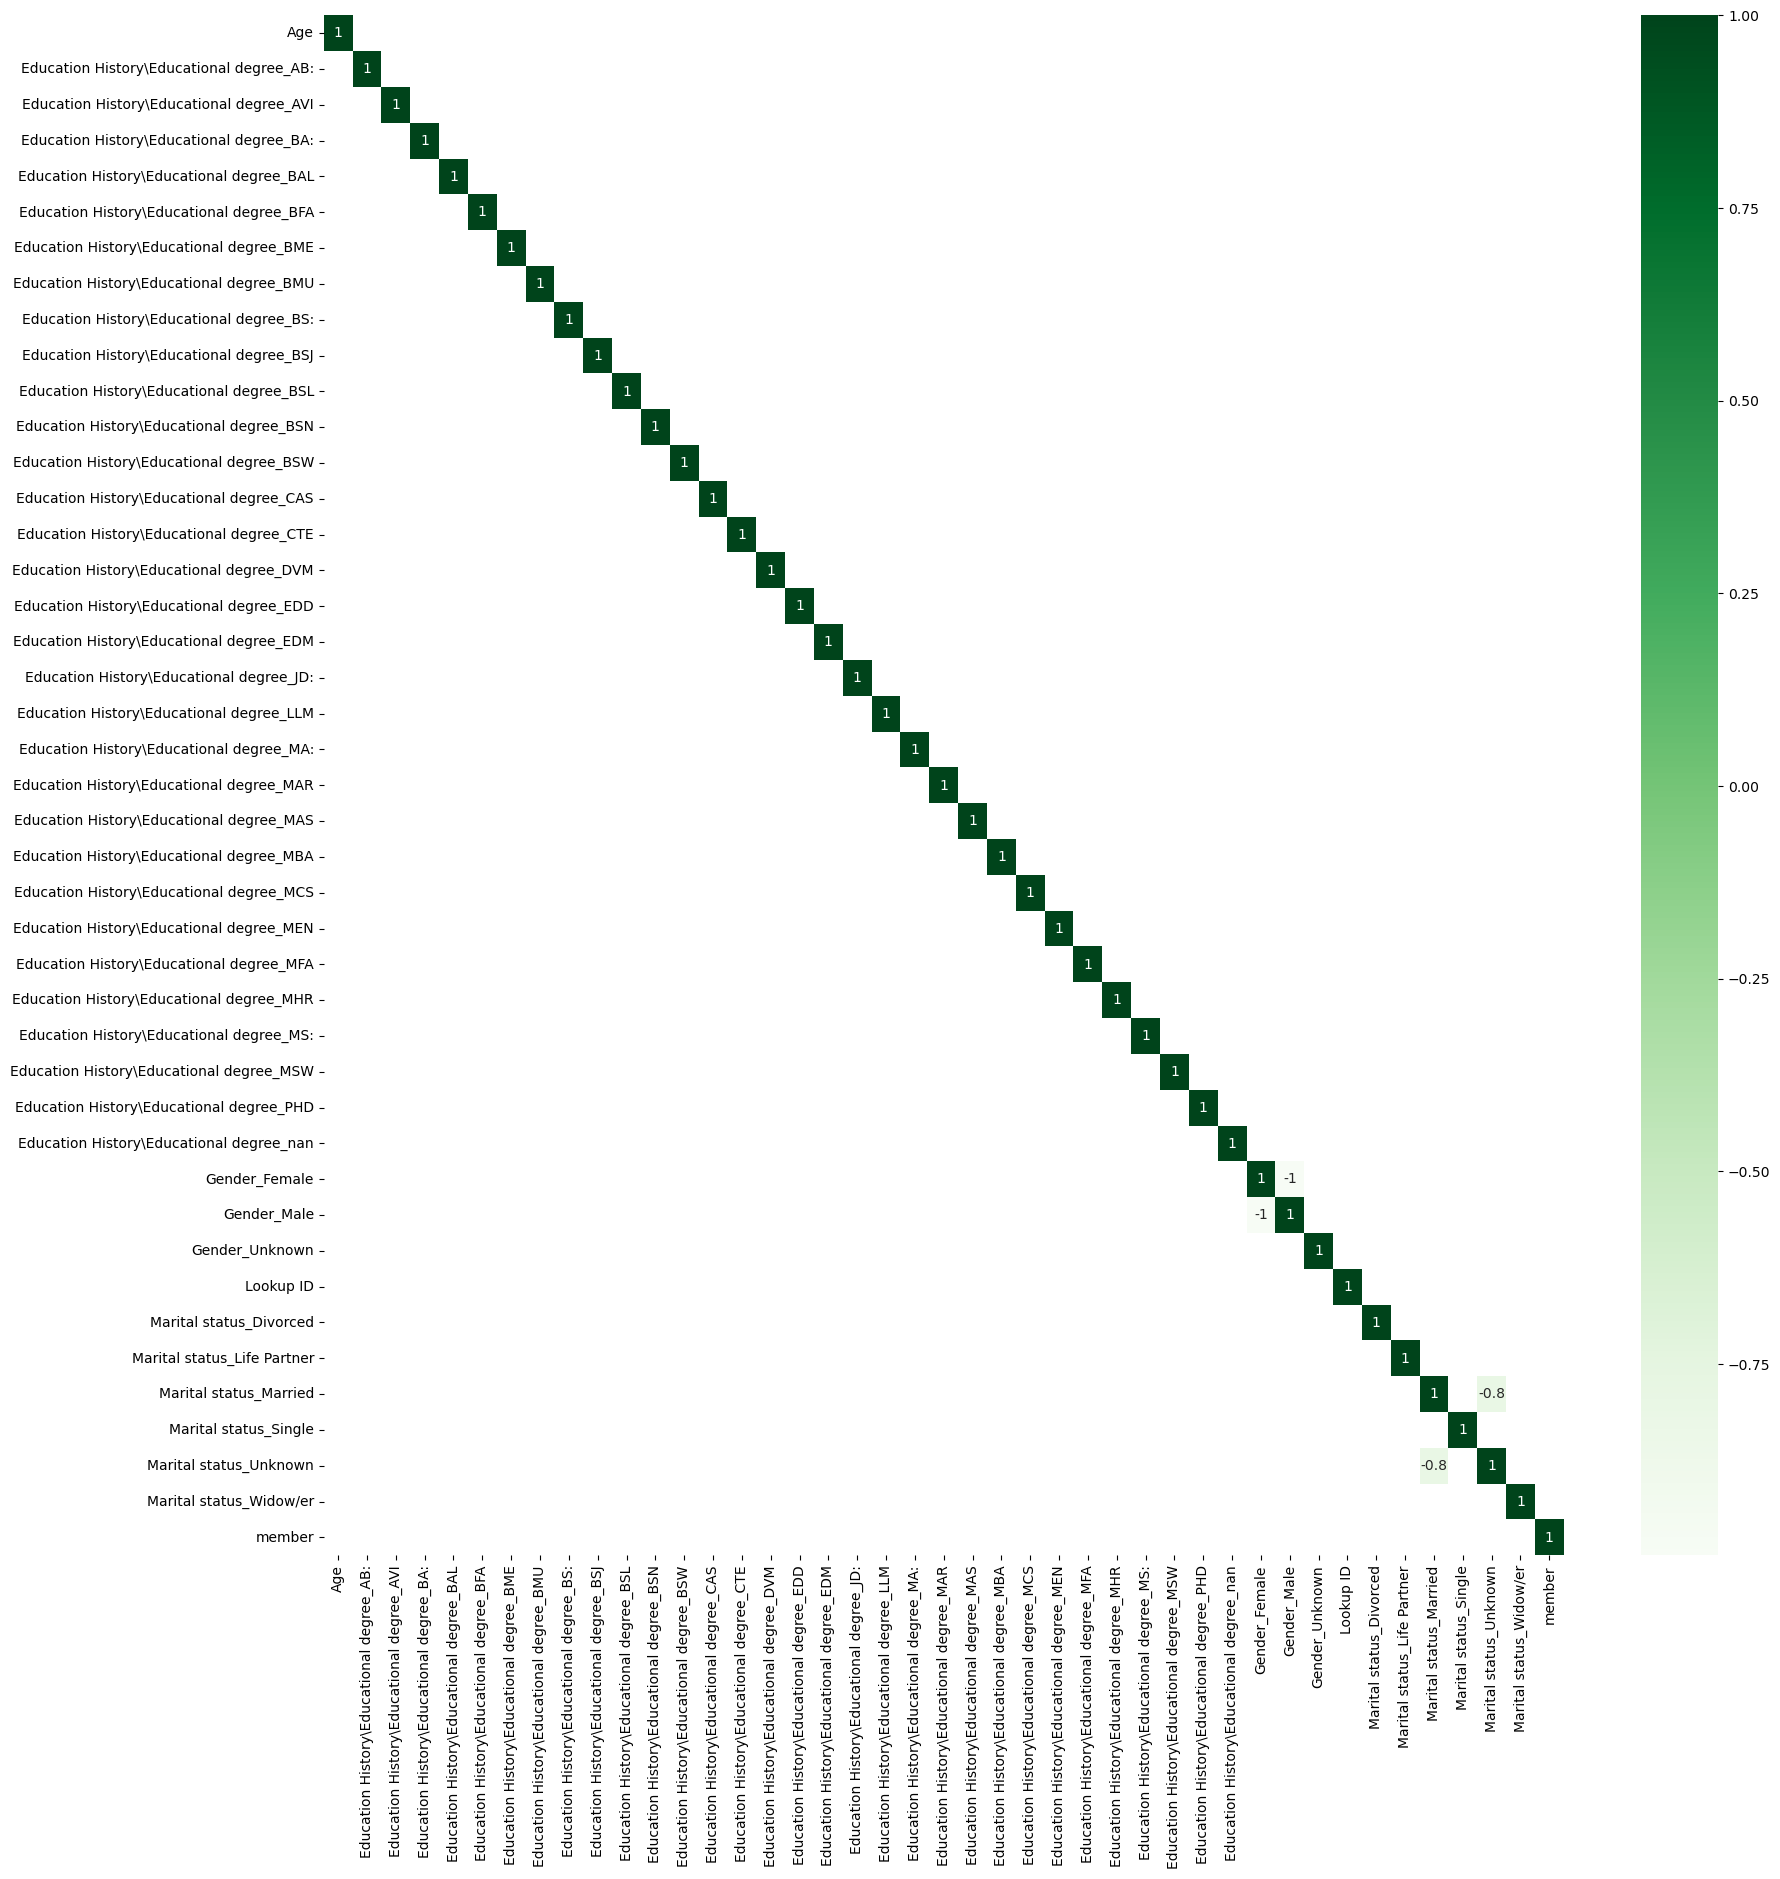

In [8]:
cor = class_mem.corr()
cor = cor[(cor>0.5)|(cor<-0.5)]
plt.figure(figsize=(20,20))
sns.heatmap(cor, annot=True, cmap= 'Greens')

In [9]:
# eliminating columns that are highly correlated
class_mem.drop(['Marital status_Unknown', 'Gender_Male'], axis=1, inplace=True)

In [10]:
class_mem1 = class_mem[['Lookup ID','Age', 'Education History\Educational degree_AB:',
       'Education History\Educational degree_AVI',
       'Education History\Educational degree_BA:',
       'Education History\Educational degree_BAL',
       'Education History\Educational degree_BFA',
       'Education History\Educational degree_BME',
       'Education History\Educational degree_BMU',
       'Education History\Educational degree_BS:',
       'Education History\Educational degree_BSJ',
       'Education History\Educational degree_BSL',
       'Education History\Educational degree_BSN',
       'Education History\Educational degree_BSW',
       'Education History\Educational degree_CAS',
       'Education History\Educational degree_CTE',
       'Education History\Educational degree_DVM',
       'Education History\Educational degree_EDD',
       'Education History\Educational degree_EDM',
       'Education History\Educational degree_JD:',
       'Education History\Educational degree_LLM',
       'Education History\Educational degree_MA:',
       'Education History\Educational degree_MAR',
       'Education History\Educational degree_MAS',
       'Education History\Educational degree_MBA',
       'Education History\Educational degree_MCS',
       'Education History\Educational degree_MEN',
       'Education History\Educational degree_MFA',
       'Education History\Educational degree_MHR',
       'Education History\Educational degree_MS:',
       'Education History\Educational degree_MSW',
       'Education History\Educational degree_PHD',
       'Education History\Educational degree_nan', 'Gender_Female',
       'Gender_Unknown', 'Marital status_Divorced',
       'Marital status_Life Partner', 'Marital status_Married',
       'Marital status_Single', 'Marital status_Widow/er', 'member']]

### Model Selection and Data Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(class_mem1.iloc[:, :-1], class_mem1['member'], shuffle=True,
                                                    test_size=0.2, random_state=40)

In [12]:
# Undersampling to reduce maximum number of classes
# X, y = RandomUnderSampler().fit_resample(X_train, y_train)

In [13]:
# Oversampling to increase minimum number of classes by a ratio
X, y = SMOTE(sampling_strategy=0.2).fit_resample(X_train, y_train)

## Model Development

### Logistic Regression

In [14]:
lr = LogisticRegression()
lr.fit(X_train.iloc[:,1:], y_train)

train_pred = lr.predict(X_train.iloc[:,1:])
test_pred = lr.predict(X_test.iloc[:,1:])

print('Train: ', f1_score(train_pred, y_train))
print('Test: ', f1_score(test_pred, y_test))

Train:  0.29160935350756534
Test:  0.19108280254777069


/Users/smitmalik/miniforge3/envs/DataViz/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Hyper-Parameter Tuning and Cross-Validation

In [15]:
# defining a space for the hyperopt to explore
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform("n_estimators", 50, 500, 50),
        'seed': 0}

In [16]:
# defining cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [17]:
def xgb_cv(space, random_state=0, cv=cv, X= X_train.iloc[:, 1:], y= y_train):
    '''
    The function helps in finding the best parameters using hyperopt and cross-validation
    1. define a closed space for hyperopt to explore
    2. iterate over k-folds
    3. use parameters to run XGBClassifier
    4. calculate losses
    '''
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators' : int(space['n_estimators']), 
              'max_depth' : int(space['max_depth']), 
              'gamma' : space['gamma'], 
              'reg_alpha' : int(space['reg_alpha']),
              'min_child_weight' : int(space['min_child_weight']),
              'colsample_bytree' : int(space['colsample_bytree']),
              'scale_pos_weight' : 86240/761}
    
    # we use this params to create a new LGBM Regressor
    model = xgb.XGBClassifier(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = cross_val_score(model, X, y, cv=cv, scoring= make_scorer(f1_score, average = 'macro'), n_jobs=-1).mean()

    return score

In [18]:
# trials will contain logging information
trials = Trials()

best=fmin(fn = xgb_cv, # function to optimize
          space = space, 
          algo = tpe.suggest,  # optimization algorithm, hyperopt will select its parameters automatically from the
                               # defined space
          max_evals = 50,  # maximum number of iterations
          trials = trials,  # logging
#           rstate=np.random.RandomState(random_state)  # fixing random state for the reproducibility
         )

# running model on the test set
model = xgb.XGBClassifier(n_estimators =int(best['n_estimators']), max_depth = int(best['max_depth']), 
                          gamma = best['gamma'], reg_alpha = int(best['reg_alpha']),
                          min_child_weight=int(best['min_child_weight']),
                          colsample_bytree=int(best['colsample_bytree']),
                          scale_pos_weight = 86240/761, #early_stopping_rounds=10
                          eval_metric="auc")

# fitting model on train set again
model.fit(X_train.iloc[:,1:], y_train)
# calculating losses on test set
test_pred_score = f1_score(y_test, model.predict(X_test.iloc[:, 1:]), average='macro')

print("Best F1 {:.3f} params {}".format( xgb_cv(best), best))

100%|█████████| 50/50 [05:10<00:00,  6.20s/trial, best loss: 0.4811555851685817]
Best F1 0.481 params {'colsample_bytree': 0.8727713613512932, 'gamma': 8.967657354969484, 'max_depth': 3.0, 'min_child_weight': 10.0, 'n_estimators': 100.0, 'reg_alpha': 168.0, 'reg_lambda': 0.8014380812635988}


In [19]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 0.52944634546822, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [0],
    'gamma': [0],
    'max_depth': [0],
    'min_child_weight': [0],
    'n_estimators': [0],
    'reg_alpha': [0],
    'reg_lambda': [0]},
   'vals': {'colsample_bytree': [0.7546296364887521],
    'gamma': [2.483323091370261],
    'max_depth': [14.0],
    'min_child_weight': [7.0],
    'n_estimators': [450.0],
    'reg_alpha': [165.0],
    'reg_lambda': [0.6240008225841586]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 4, 26, 21, 31, 5, 97000),
  'refresh_time': datetime.datetime(2023, 4, 26, 21, 31, 17, 291000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 0.4867304289919559, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs':

In [20]:
# creating a dataframe that contains all model results
results = []
for x in trials.trials:
    loss = x['result']['loss']
    colsample_bytree = x['misc']['vals']['colsample_bytree'][0]
    gamma = x['misc']['vals']['gamma'][0]
    min_child_weight = x['misc']['vals']['min_child_weight'][0]
    max_depth = x['misc']['vals']['max_depth'][0]
    reg_alpha = x['misc']['vals']['reg_alpha'][0]
    reg_lambda = x['misc']['vals']['reg_lambda'][0]
    n_estimators = x['misc']['vals']['n_estimators'][0]
    results.append([loss, colsample_bytree, gamma, min_child_weight, max_depth, reg_alpha, reg_lambda, n_estimators])
results = np.array(results)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

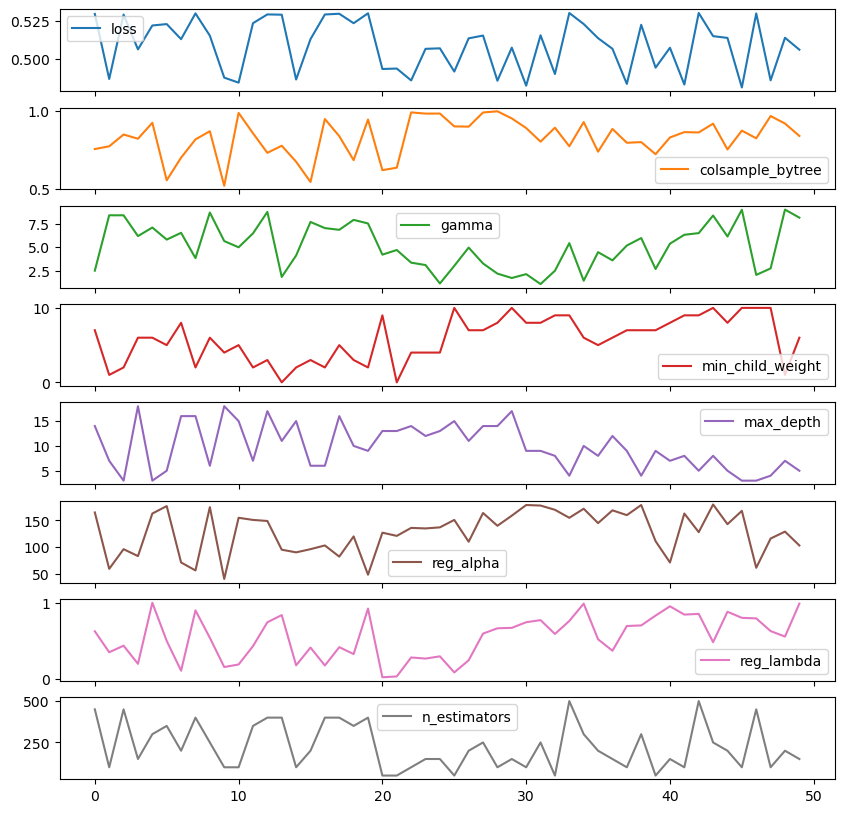

In [21]:
# visualizing results
results_df=pd.DataFrame(results,
                           columns=['loss', 'colsample_bytree', 'gamma', 'min_child_weight', 'max_depth', 
                                    'reg_alpha', 'reg_lambda', 'n_estimators'])
                                    
results_df.plot(subplots=True,figsize=(10, 10))

In [22]:
y_train.value_counts()

0    68981
1      619
Name: member, dtype: int64

In [23]:
# again fitting model with best the parameters
new_model = xgb.XGBClassifier(n_estimators =int(best['n_estimators']), 
                              max_depth = int(best['max_depth']), 
                              gamma = best['gamma'], 
                              reg_alpha = int(best['reg_alpha']),
                              min_child_weight=int(best['min_child_weight']),
                              colsample_bytree=int(best['colsample_bytree']),
                              scale_pos_weight = 86240/761, #early_stopping_rounds=10
                              eval_metric="auc")

In [24]:
new_model.fit(X_train.iloc[:, 1:], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=8.967657354969484,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

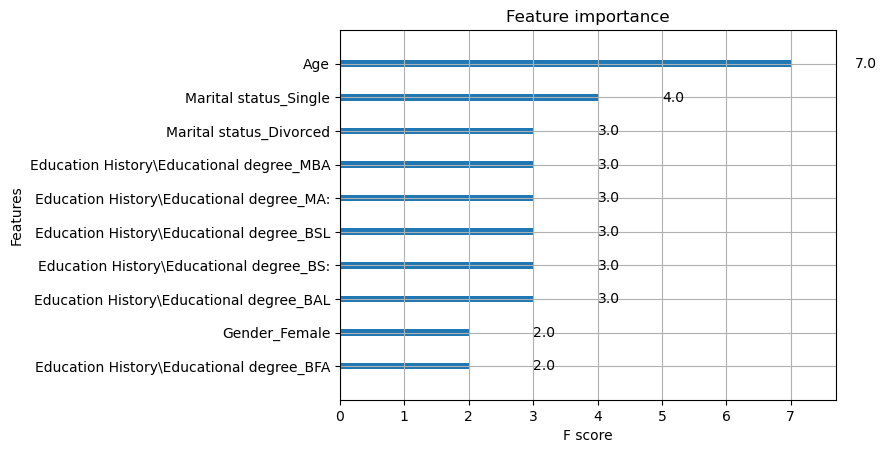

In [25]:
xgb.plot_importance(new_model, max_num_features=10)

## Model Evaluation

### F1-Score (Macro)

In [26]:
train_pred = new_model.predict(X_train.iloc[:, 1:])
test_pred = new_model.predict(X_test.iloc[:, 1:])

print('Train Score: ', f1_score(train_pred, y_train, average='macro'))
print('Test Score: ', f1_score(test_pred, y_test, average='macro'))

Train Score:  0.48280083720444544
Test Score:  0.4800986457684483


### Confusion Matrix

<AxesSubplot:>

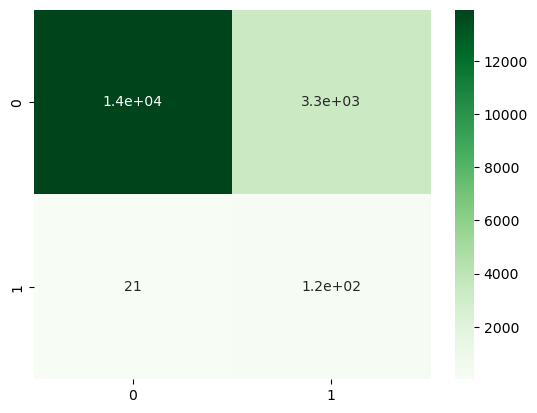

In [27]:
sns.heatmap(confusion_matrix(y_test, test_pred), annot=True, cmap= 'Greens')

### Classification Report

In [28]:
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89     55850
           1       0.84      0.04      0.07     13750

    accuracy                           0.81     69600
   macro avg       0.82      0.52      0.48     69600
weighted avg       0.81      0.81      0.73     69600



### Likelihood Prediction (Probability)

In [29]:
train_proba0 = new_model.predict_proba(X_train.iloc[:, 1:])[:][:,0]
train_proba1 = new_model.predict_proba(X_train.iloc[:, 1:])[:][:,1]

test_proba0 = new_model.predict_proba(X_test.iloc[:, 1:])[:][:,0]
test_proba1 = new_model.predict_proba(X_test.iloc[:, 1:])[:][:,1]

### Area Under the ROC (Receiver Operating Characteristics) Curve Score

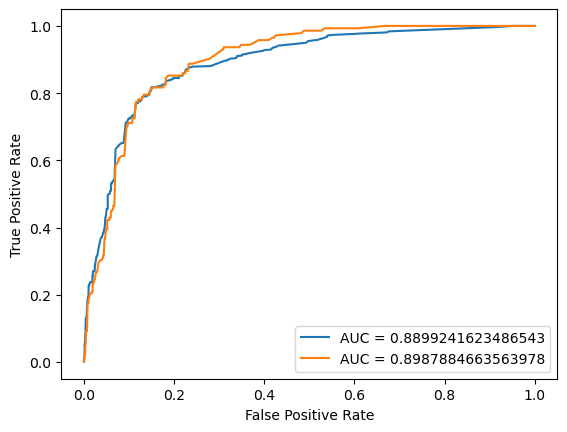

In [30]:
auc_train = roc_auc_score(y_train, train_proba1)
auc_test = roc_auc_score(y_test, test_proba1)


fpr, tpr, _ = roc_curve(y_train,  train_proba1)
fpr1, tpr1, _1 = roc_curve(y_test,  test_proba1)
#create ROC curve
plt.plot(fpr,tpr, label = 'AUC = '+str(auc_train))
plt.plot(fpr1, tpr1, label = 'AUC = '+str(auc_test))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Balanced Accuracy Score

In [31]:
print('Train Balanced Accuracy Score: ', balanced_accuracy_score(y_train, train_pred))
print('Test Balanced Accuracy Score: ', balanced_accuracy_score(y_test, test_pred))

Train Balanced Accuracy Score:  0.824136338823275
Test Balanced Accuracy Score:  0.8297008133743652


## Consolidating Results

In [32]:
results = pd.DataFrame(X_train['Lookup ID'].values,
                       columns= ['Lookup ID'])

results['Probability0'] = train_proba0
results['Probability1'] = train_proba1
results['pred'] = train_pred
results['member'] = y_train.values

In [33]:
results_test = pd.DataFrame(X_test['Lookup ID'].values,
                       columns= ['Lookup ID'])

results_test['Probability0'] = test_proba0
results_test['Probability1'] = test_proba1
results_test['pred'] = test_pred
results_test['member'] = y_test.values

In [34]:
probability_result = pd.concat([results, results_test], axis=0)

In [35]:
probability_result

,Lookup ID,Probability0,Probability1,pred,member
0,10848142,0.476838,0.523162,1,0
1,10672427,0.499433,0.500567,1,0
2,10692093,0.657742,0.342258,0,0
3,10764063,0.657742,0.342258,0,0
4,10333337,0.508873,0.491127,0,0
...,...,...,...,...,...
17396,10807740,0.681805,0.318195,0,0
17397,10392621,0.598420,0.401580,0,0
17398,10383278,0.523502,0.476498,0,0
17399,10659532,0.681805,0.318195,0,0


## Result Analysis and Priority Labelling

In [36]:
not_match = probability_result.loc[probability_result['pred'] != probability_result['member']]

In [37]:
not_match['pred'].value_counts()

1    16556
0      120
Name: pred, dtype: int64

In [38]:
not_match

,Lookup ID,Probability0,Probability1,pred,member
0,10848142,0.476838,0.523162,1,0
1,10672427,0.499433,0.500567,1,0
7,10804678,0.465379,0.534621,1,0
33,10771198,0.423468,0.576532,1,0
34,10555292,0.348801,0.651199,1,0
...,...,...,...,...,...
17373,10826226,0.485350,0.514650,1,0
17379,10509550,0.388315,0.611685,1,0
17380,10768254,0.423452,0.576548,1,0
17384,10832032,0.465379,0.534621,1,0


In [39]:
not_match['Conversion'] = pd.qcut(not_match['Probability1'], 3, labels= ['Low', 'Moderate', 'High'])

/var/folders/98/4w5bzj557j733_gyzdw052200000gn/T/ipykernel_51568/2833929212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_match['Conversion'] = pd.qcut(not_match['Probability1'], 3, labels= ['Low', 'Moderate', 'High'])


In [40]:
not_match

,Lookup ID,Probability0,Probability1,pred,member,Conversion
0,10848142,0.476838,0.523162,1,0,Low
1,10672427,0.499433,0.500567,1,0,Low
7,10804678,0.465379,0.534621,1,0,Moderate
33,10771198,0.423468,0.576532,1,0,Moderate
34,10555292,0.348801,0.651199,1,0,High
...,...,...,...,...,...,...
17373,10826226,0.485350,0.514650,1,0,Low
17379,10509550,0.388315,0.611685,1,0,High
17380,10768254,0.423452,0.576548,1,0,Moderate
17384,10832032,0.465379,0.534621,1,0,Moderate


In [41]:
match = probability_result.loc[probability_result['pred'] == probability_result['member']]

In [42]:
match0 = match.loc[match['pred']==0]
match1 = match.loc[match['pred']==1]

In [43]:
match1['Probability1'].shape

(641,)

In [44]:
match0['Probability1'].shape

(69684,)

In [45]:
match0['Conversion'] = pd.qcut(match0['Probability1'], 3, labels= ['Low', 'Moderate', 'High'])

/var/folders/98/4w5bzj557j733_gyzdw052200000gn/T/ipykernel_51568/1207930108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match0['Conversion'] = pd.qcut(match0['Probability1'], 3, labels= ['Low', 'Moderate', 'High'])


In [46]:
match0

,Lookup ID,Probability0,Probability1,pred,member,Conversion
2,10692093,0.657742,0.342258,0,0,Moderate
3,10764063,0.657742,0.342258,0,0,Moderate
4,10333337,0.508873,0.491127,0,0,High
5,10383406,0.560314,0.439686,0,0,High
6,10629909,0.636020,0.363980,0,0,Moderate
...,...,...,...,...,...,...
17396,10807740,0.681805,0.318195,0,0,Low
17397,10392621,0.598420,0.401580,0,0,High
17398,10383278,0.523502,0.476498,0,0,High
17399,10659532,0.681805,0.318195,0,0,Low


In [47]:
match1['Conversion'] = pd.qcut(match1['Probability0'], 3, labels= ['Low', 'Moderate', 'High'])

/var/folders/98/4w5bzj557j733_gyzdw052200000gn/T/ipykernel_51568/1036158676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match1['Conversion'] = pd.qcut(match1['Probability0'], 3, labels= ['Low', 'Moderate', 'High'])


In [48]:
match1

,Lookup ID,Probability0,Probability1,pred,member,Conversion
134,11956527,0.483537,0.516463,1,1,High
217,11455989,0.293896,0.706104,1,1,Low
244,10904787,0.366915,0.633085,1,1,Moderate
258,11653336,0.357661,0.642339,1,1,Moderate
364,11642726,0.357661,0.642339,1,1,Moderate
...,...,...,...,...,...,...
17049,13800419,0.317539,0.682461,1,1,Low
17103,11406929,0.375343,0.624657,1,1,Moderate
17108,11423694,0.443815,0.556185,1,1,High
17137,11717064,0.437527,0.562473,1,1,High


In [49]:
not_match.to_csv('not_match.csv', index= False)
match0.to_csv('match0.csv', index= False)
match1.to_csv('match1.csv', index= False)

In [50]:
not_match.loc[(not_match['pred'] == 0)&(not_match['member'] == 1)]

,Lookup ID,Probability0,Probability1,pred,member,Conversion
229,14065846,0.626488,0.373512,0,1,Low
633,11314814,0.517551,0.482449,0,1,Low
1154,10809806,0.626488,0.373512,0,1,Low
1244,10901465,0.618952,0.381048,0,1,Low
2574,12050791,0.657742,0.342258,0,1,Low
...,...,...,...,...,...,...
13451,14085964,0.637186,0.362814,0,1,Low
16649,10936700,0.618952,0.381048,0,1,Low
16933,11700497,0.537168,0.462832,0,1,Low
16964,10367338,0.547436,0.452564,0,1,Low


## Visualizations in Tableau